# Parameter Estimation for Ion Exchange

This demonstration will present the steps for setting up and conducting a parameter estimation for the WaterTAP ion exchange (IX) model. This tutorial will go through the steps to fit the IX model to breakthrough data for PFAS species. 

## Model Equations

The [WaterTAP IX model](https://watertap.readthedocs.io/en/stable/technical_reference/unit_models/ion_exchange_0D.html) we will be using is an implementation of the Clark model. This model includes three parameters related to the bed capacity, equilibrium, and mass transfer of the solute of interest on to the media. The governing equation is shown below.

$$
\frac{\textcolor{red}{C_b}}{\textcolor{red}{C_0}} =
\frac{1}{\left( 1 +
\left(2^{\textcolor{RoyalBlue}{n} - 1} - 1\right)
\exp\left[
\frac{\textcolor{RoyalBlue}{k_T} Z (\textcolor{RoyalBlue}{n} - 1)}
{\textcolor{RoyalBlue}{BV_{50}} \, u_{bed}}
\left(\textcolor{RoyalBlue}{BV_{50}} - \textcolor{green}{BV}\right)
\right]
\right)^{\tfrac{1}{\textcolor{RoyalBlue}{n} - 1}}}
$$

<!-- **Color Legend:**   -->
- $u_{bed}$ = bed loading rate, adopted from pilot experiments
- $Z$ = bed depth, adopted from pilot experiments
- $\textcolor{red}{C_b/C_0}$ = Effluent concentration ratio, determined from pilot experiments
- $\textcolor{green}{BV}$ = Bed volumes treated, determined from pilot experiments
- $\textcolor{RoyalBlue}{BV_{50}}$, $\textcolor{RoyalBlue}{k_{T}}$, and $\textcolor{RoyalBlue}{n}$ = Clark model parameters to be fit with parameter estimation

In essence, we want to estimate the values for $\textcolor{RoyalBlue}{BV_{50}}$, $\textcolor{RoyalBlue}{k_{T}}$, and $\textcolor{RoyalBlue}{n}$ to know the $\textcolor{green}{BV}$ that the relative effluent concentration is $\textcolor{red}{ C_b/C_0}$. 


In [ ]:
import os
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

import pyomo.contrib.parmest.parmest as parmest
from pyomo.environ import (
    Var,
    ComponentUID,
    ConcreteModel,
    Suffix,
    Reals,
    value,
    assert_optimal_termination,
    units as pyunits,
)
from idaes.core import (
    FlowsheetBlock,
    UnitModelCostingBlock,
)
import idaes.core.util.scaling as iscale

from idaes.core.util.model_statistics import degrees_of_freedom

from watertap.core.solvers import get_solver
from watertap.costing import WaterTAPCosting
from watertap.property_models.multicomp_aq_sol_prop_pack import MCASParameterBlock
from watertap.unit_models.ion_exchange_0D import IonExchange0D

solver = get_solver()

# with open(f"pfas_properties.yaml", "r") as f:
#     pfas_properties = yaml.load(f, Loader=yaml.FullLoader)

# with open(f"resin_properties.yaml", "r") as f:
#     resin_properties = yaml.load(f, Loader=yaml.FullLoader)

# import logging
# import warnings
# from watertap.core.util.model_diagnostics.infeasible import *
# logging.getLogger("pyomo").setLevel(logging.CRITICAL)
# warnings.filterwarnings("ignore")

,bv,cb,species,resin,c0,c_norm,curve_id
0,15131.51332,0.044226,PFOA,a694e,15.8,0.002799,1
1,56630.53237,0.060187,PFOA,a694e,15.8,0.003809,1
2,69166.69438,0.065008,PFOA,a694e,15.8,0.004114,1
3,77002.62694,1.971868,PFOA,a694e,15.8,0.124802,1
4,85257.53999,3.417351,PFOA,a694e,15.8,0.216288,1
5,103017.65700,4.693413,PFOA,a694e,15.8,0.297051,1
6,109548.43210,6.311309,PFOA,a694e,15.8,0.399450,1
7,135124.53030,8.801915,PFOA,a694e,15.8,0.557083,1
8,152490.60620,11.404748,PFOA,a694e,15.8,0.721820,1
9,178060.05390,13.664583,PFOA,a694e,15.8,0.864847,1


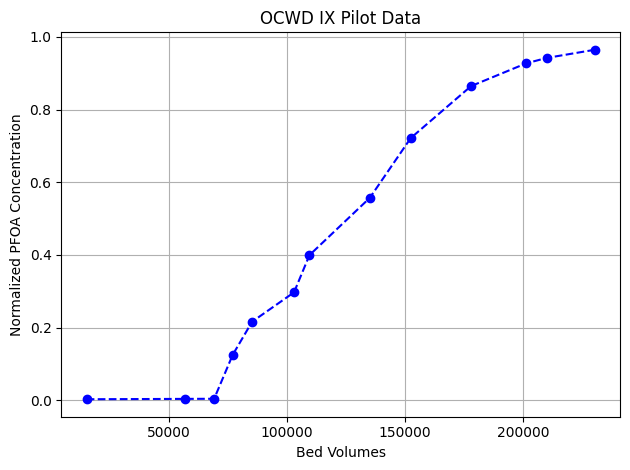

In [132]:
all_data = pd.read_csv("breakthrough_data.csv")

data = all_data[all_data.curve_id == 1].copy().reset_index(drop=True)

fig, ax = plt.subplots()
ax.plot(data["bv"], data["c_norm"], marker="o", color="blue", ls="--")
ax.set_xlabel("Bed Volumes")
ax.set_ylabel("Normalized PFOA Concentration")
ax.set_title("OCWD IX Pilot Data")
ax.grid(visible=True)
fig.tight_layout()

data

In [125]:
def build_ix_ocwd_pilot(
    # species="PFOA", resin="calgon_calres_2301", theta_dict=dict(), c_norm=0.5, **kwargs
    data
):
    """
    Build for OCWD IX Pilot System
    """
    # PILOT SYSTEM INFO

    global ion_props, resin_data

    bed_depth = 29 * pyunits.inch
    bed_vol = 95.44 * pyunits.inches**3
    col_diam = 2.05 * pyunits.inch
    flow_rate = 0.2 * pyunits.gallon / pyunits.minute
    ebct = 2.07 * pyunits.minute
    c0 = 15.8 * pyunits.ng / pyunits.L
    mw = 0.41407 * pyunits.kg / pyunits.mol
    species = data.iloc[0].species
    resin = data.iloc[0].resin

    # pfas_data = pfas_properties[species]
    # resin_data = resin_properties[resin]
    resin_data = {
        # 'base_type': 'Strong',
 'density': 720,
 'diameter': 0.000675,
#  'functional_group': 'Complex Amino',
#  'ground_bool': False,
#  'pore_composition': 'Polystyrene',
#  'pore_structure': 'Gel',
#  'porosity': 0.4784,
#  'references': ['ellis_2022', 'wang_2022'],
#  'title': 'Purofine PFA694E',
#  'type': 'Strong Base Type I Gel Polystyrene-Divinylbenzene'
}

    ion_props = {
        "solute_list": ["PFOA"],
        "mw_data": {"H2O": 0.018, "PFOA": 0.41407},
        "molar_volume_data": {("Liq", "PFOA"): 0.000272},
        "diffus_calculation": "HaydukLaudie",
        "charge": {"PFOA": -1},
        
    }

    m = ConcreteModel()
    m.fs = FlowsheetBlock(dynamic=False)
    m.fs.properties = MCASParameterBlock(**ion_props)
    ix_config = {
        "property_package": m.fs.properties,
        "target_ion": species,
        "isotherm": "freundlich",
        "regenerant":"single_use"
    }
    m.fs.unit = ix = IonExchange0D(**ix_config)

    # Set pilot feed conditions
    pfas_mol_flow = pyunits.convert(
        c0/ mw
        * flow_rate, to_units=pyunits.mol / pyunits.s
    )

    h2o_mol_flow = 55.5 * pyunits.mol / pyunits.L * flow_rate
    ix.process_flow.properties_in[0].flow_mol_phase_comp["Liq", "H2O"].fix(h2o_mol_flow)
    ix.process_flow.properties_in[0].flow_mol_phase_comp["Liq", species].fix(
        pfas_mol_flow
    )
    # ix.process_flow.properties_out[0].flow_mol_phase_comp["Liq", "H2O"].set_value(h2o_mol_flow)
    # ix.process_flow.properties_out[0].flow_mol_phase_comp["Liq", species].set_value(
    #     pfas_mol_flow
    # )
    # m.fs.unit.regeneration_stream[0.0].flow_mol_phase_comp["Liq", "PFOA"].fix(0)
    ix.process_flow.properties_in[0].pressure.fix(101325)
    ix.process_flow.properties_in[0].temperature.fix(298)

    # Adjust bounds for pilot system
    ix.bed_depth.setlb(0)
    ix.col_diam.set_value(col_diam)
    ix.bed_vol_tot.setub(bed_vol * 1.001)
    ix.col_diam.setlb(0)
    ix.ebct.setlb(0)
    ix.vel_bed.setlb(0)
    ix.vel_bed.setub(1)
    ix.freundlich_n.setlb(1.05)
    ix.freundlich_n.setub(100)
    ix.col_height_to_diam_ratio.setlb(0)
    ix.bv.setlb(None)

    ix.resin_bulk_dens.fix(resin_data["density"] * pyunits.kg / pyunits.m**3)
    ix.resin_diam.fix(resin_data["diameter"])
    ix.bed_depth.fix(bed_depth)
    ix.ebct.fix(ebct)
    ix.number_columns.fix(1)
    ix.c_norm.fix(0.5)

    # m.fs.unit.col_diam.fix()
    m.fs.unit.eq_c_traps.deactivate()
    m.fs.unit.c_traps.fix()
    m.fs.unit.eq_tb_traps.deactivate()
    m.fs.unit.tb_traps.fix()
    m.fs.unit.eq_traps.deactivate()
    m.fs.unit.traps.fix()
    m.fs.unit.eq_c_norm_avg.deactivate()
    m.fs.unit.c_norm_avg.fix(1e-3)
    # m.fs.unit.eq_mass_transfer_target_fr.deactivate()
    # m.fs.unit.eq_mass_transfer_regen.deactivate()
    m.fs.unit.process_flow.mass_transfer_term.fix(0)
    # m.fs.unit.regeneration_stream.deactivate()

    good_initial_guess = {
        "fs.unit.bv_50": 120000,
        "fs.unit.mass_transfer_coeff": 0.2,
        "fs.unit.freundlich_n": 2.0,
    }
    for theta, val in good_initial_guess.items():
        ixv = m.find_component(theta)
        ixv.fix(val)

    m.fs.properties.set_default_scaling(
        "flow_mol_phase_comp", 1 / value(h2o_mol_flow), index=("Liq", "H2O")
    )
    m.fs.properties.set_default_scaling(
        # "flow_mol_phase_comp", 1e10, index=("Liq", species)
        "flow_mol_phase_comp", 1 / value(pfas_mol_flow), index=("Liq", species)
    )
    # print(1 / value(pfas_mol_flow))

    iscale.set_scaling_factor(ix.bed_vol_tot, 1e4)
    iscale.calculate_scaling_factors(m)

    assert degrees_of_freedom(m) == 0
    print(f"dof = {degrees_of_freedom(m)}")
    m.fs.unit.initialize()
    results = solver.solve(m)
    assert_optimal_termination(results)

    ix.c_norm.fix(data.iloc[0]["c_norm"])
    print(f"Running with c_norm = {value(ix.c_norm[species])}")

    assert degrees_of_freedom(m) == 0
    m.fs.unit.initialize()
    results = solver.solve(m)
    assert_optimal_termination(results)


    return m



m = build_ix_ocwd_pilot(data)

# print(f"dof = {degrees_of_freedom(m)}")
# # m.fs.unit.process_flow.initialize()
# # m.fs.unit.process_flow.properties_in[0].display()
# try:
#     m.fs.unit.initialize()
# except:
#     print_infeasible_constraints(m)
#     print_variables_close_to_bounds(m)

# tbs = []
# bvs = []
# xs = data.c_norm.tolist()
# xs.append(0.5)
# for x in xs:
#     m.fs.unit.c_norm.fix(x)
#     m.fs.unit.initialize()
#     print(f"c_norm = {x}")
#     print(f"tb = {value(m.fs.unit.t_breakthru)}")
#     print(f"dof = {degrees_of_freedom(m)}")
#     results = solver.solve(m)
#     assert_optimal_termination(results)
#     tbs.append(value(m.fs.unit.t_breakthru))
#     bvs.append(value(m.fs.unit.bv))

# fig, ax = plt.subplots()
# ax.plot(bvs, xs, marker="o", color="blue", ls="--", label="Model")

# ax.plot(data["bv"], data["c_norm"], marker="o", color="red", ls="--", label="Data")
# ax.set_xlabel("Normalized PFOA Concentration")
# ax.set_ylabel("Breakthrough Time (s)")
# ax.set_title("OCWD IX Pilot Model Breakthrough Curve")
# ax.legend()


dof = 0
2026-01-14 12:59:34 [INFO] idaes.init.fs.unit: Initialization Step 1a Complete.
2026-01-14 12:59:34 [INFO] idaes.init.fs.unit: Initialization Step 1b Complete.
2026-01-14 12:59:34 [INFO] idaes.init.fs.unit: Initialization Step 1c Complete.
2026-01-14 12:59:34 [INFO] idaes.init.fs.unit: Initialization Step 2 optimal - Optimal Solution Found.
2026-01-14 12:59:34 [INFO] idaes.init.fs.unit: Initialization Complete: optimal - Optimal Solution Found
Running with c_norm = 0.002799096
2026-01-14 12:59:34 [INFO] idaes.init.fs.unit: Initialization Step 1a Complete.
2026-01-14 12:59:34 [INFO] idaes.init.fs.unit: Initialization Step 1b Complete.
2026-01-14 12:59:34 [INFO] idaes.init.fs.unit: Initialization Step 1c Complete.
2026-01-14 12:59:34 [INFO] idaes.init.fs.unit: Initialization Step 2 optimal - Optimal Solution Found.
2026-01-14 12:59:34 [INFO] idaes.init.fs.unit: Initialization Complete: optimal - Optimal Solution Found


In [126]:
from watertap.kurby import *
check_scaling(m.fs.unit)





VAR NAME                                                     |       UNSCALED VALUE |       SCALING FACTOR |         SCALED VALUE |
resin_diam                                                   |           6.7500e-04 |           10000.0000 |               6.7500 |
resin_bulk_dens                                              |               0.7200 |              10.0000 |               7.2000 |
resin_surf_per_vol                                           |            4497.0314 |           1.0000e-03 |               4.4970 |
unit.c_norm[PFOA]                                            |           2.7991e-03 |              10.0000 |               0.0280 |
bed_vol_tot                                                  |           1.5654e-03 |           10000.0000 |              15.6540 |
bed_depth                                                    |               0.7366 |               1.0000 |               0.7366 |
bed_porosity                                                 |           

In [127]:

theta_names = ['fs.unit.bv_50', 'fs.unit.mass_transfer_coeff', 'fs.unit.freundlich_n']

In [128]:
def SSE(m, data):
    expr = (float(data.iloc[0]["bv"])- m.fs.unit.bv)** 2
    return expr

In [129]:

pest = parmest.Estimator(build_ix_ocwd_pilot, data, theta_names, SSE, tee=False)

In [130]:
# solve the parameter estimation problem
obj, theta = pest.theta_est()

# display results
print("theta:\n", theta)

dof = 0


2026-01-14 12:59:35 [INFO] idaes.init.fs.unit: Initialization Step 1a Complete.
2026-01-14 12:59:35 [INFO] idaes.init.fs.unit: Initialization Step 1b Complete.
2026-01-14 12:59:35 [INFO] idaes.init.fs.unit: Initialization Step 1c Complete.
2026-01-14 12:59:35 [INFO] idaes.init.fs.unit: Initialization Step 2 optimal - Optimal Solution Found.
2026-01-14 12:59:35 [INFO] idaes.init.fs.unit: Initialization Complete: optimal - Optimal Solution Found
Running with c_norm = 0.002799096
2026-01-14 12:59:35 [INFO] idaes.init.fs.unit: Initialization Step 1a Complete.
2026-01-14 12:59:35 [INFO] idaes.init.fs.unit: Initialization Step 1b Complete.
2026-01-14 12:59:35 [INFO] idaes.init.fs.unit: Initialization Step 1c Complete.
2026-01-14 12:59:35 [INFO] idaes.init.fs.unit: Initialization Step 2 optimal - Optimal Solution Found.
2026-01-14 12:59:35 [INFO] idaes.init.fs.unit: Initialization Complete: optimal - Optimal Solution Found
dof = 0
2026-01-14 12:59:35 [INFO] idaes.init.fs.unit: Initialization 

dof = 0
2026-01-14 12:59:40 [INFO] idaes.init.fs.unit: Initialization Step 1a Complete.
2026-01-14 12:59:40 [INFO] idaes.init.fs.unit: Initialization Step 1b Complete.
2026-01-14 12:59:40 [INFO] idaes.init.fs.unit: Initialization Step 1c Complete.
2026-01-14 12:59:40 [INFO] idaes.init.fs.unit: Initialization Step 2 optimal - Optimal Solution Found.
2026-01-14 12:59:40 [INFO] idaes.init.fs.unit: Initialization Complete: optimal - Optimal Solution Found
Running with c_norm = 0.002799096
2026-01-14 12:59:40 [INFO] idaes.init.fs.unit: Initialization Step 1a Complete.
2026-01-14 12:59:40 [INFO] idaes.init.fs.unit: Initialization Step 1b Complete.
2026-01-14 12:59:40 [INFO] idaes.init.fs.unit: Initialization Step 1c Complete.
2026-01-14 12:59:40 [INFO] idaes.init.fs.unit: Initialization Step 2 optimal - Optimal Solution Found.
2026-01-14 12:59:40 [INFO] idaes.init.fs.unit: Initialization Complete: optimal - Optimal Solution Found
dof = 0
2026-01-14 12:59:41 [INFO] idaes.init.fs.unit: Initial

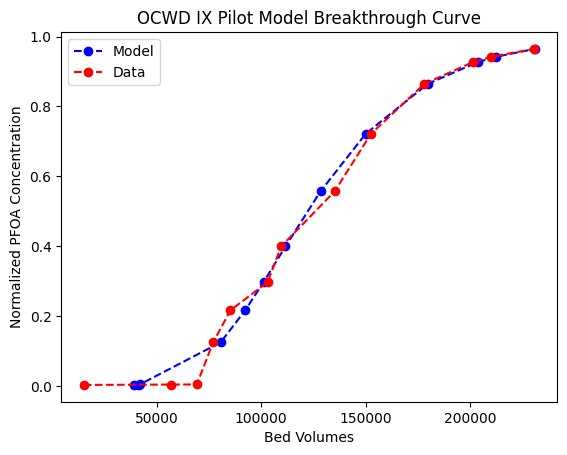

In [131]:
m = build_ix_ocwd_pilot(data)

for k, v in theta.items():
    var = m.find_component(k)
    var.fix(v)
print(f"dof = {degrees_of_freedom(m)}")
m.fs.unit.initialize()

tbs = []
bvs = []
xs = data.c_norm.tolist()
for x in xs:
    m.fs.unit.c_norm.fix(x)
    m.fs.unit.initialize()
    print(f"c_norm = {x}")
    print(f"tb = {value(m.fs.unit.t_breakthru)}")
    print(f"dof = {degrees_of_freedom(m)}")
    results = solver.solve(m)
    assert_optimal_termination(results)
    tbs.append(value(m.fs.unit.t_breakthru))
    bvs.append(value(m.fs.unit.bv))

fig, ax = plt.subplots()
ax.plot(bvs, xs, marker="o", color="blue", ls="--", label="Model")

ax.plot(data["bv"], data["c_norm"], marker="o", color="red", ls="--", label="Data")
ax.set_ylabel("Normalized PFOA Concentration")
ax.set_xlabel("Bed Volumes")
ax.set_title("OCWD IX Pilot Model Breakthrough Curve")
ax.legend()
